# Harnessing Weather Insights for Accurate Energy Load Forecasting

by Florian Schulze, Raffaela Länger, Johanna Kronfuß and Julian Janisch

** The Code was written in Visual Studio Code with the help of GitHub Copilot **

------------

# Regression Analysis

This project uses PySpark to predict energy consumption based on weather data. First, weather data from a CSV file and energy consumption data from an XML file are loaded and transformed into a structured format. Next, comprehensive feature engineering is performed, including the creation of lag features, temporal encoding, and data standardization. The prepared data is then split into training and test sets to train two models: a linear regression and a random forest regressor. Model performance is evaluated using metrics such as RMSE and R², complemented by visual analyses like scatter plots and residual plots. Finally, the results are compared to determine the most effective model for predicting energy consumption.

In [1]:
# This command installs all required dependencies listed in requirements.txt
# It ensures that all necessary libraries are available for the project
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Import important libraries

We use several imports in this project to facilitate data processing, machine learning, and visualization. The platform module helps check system compatibility, while findspark ensures that PySpark is properly configured. The Pathlib library is useful for handling file paths across different operating systems. PySpark's SparkSession is essential for initializing a Spark environment, and the functions from pyspark.sql.functions and pyspark.sql.window support data manipulation and window functions. For machine learning, we use StandardScaler and VectorAssembler to preprocess features, while LinearRegression and RandomForestRegressor provide predictive modeling capabilities. The RegressionEvaluator helps assess model performance. Finally, matplotlib.pyplot is used to visualize data and results, making model evaluation more intuitive.

In [2]:
# System and environment setup  
import platform  # Used to check system compatibility  
import findspark  # Ensures PySpark is properly initialized  
from pathlib import Path  # Facilitates file path management  

# PySpark setup  
from pyspark.sql import SparkSession  # Initializes the Spark session  
from pyspark.sql.functions import *  # Provides SQL-like functions for data transformation  
from pyspark.sql.window import Window  # Enables window functions for advanced aggregations  

# PySpark ML features and models  
from pyspark.ml.feature import StandardScaler, VectorAssembler  # Used for feature preprocessing  
from pyspark.ml.regression import LinearRegression, RandomForestRegressor  # Machine learning models  
from pyspark.ml.evaluation import RegressionEvaluator  # Evaluates model performance  

# Visualization  
import matplotlib.pyplot as plt  # Used for plotting and visualizing results  

This code initializes PySpark based on the operating system. If the system runs on Windows, it sets up PySpark using a specified local installation path; otherwise, it defaults to a common Spark path for Linux/Mac environments.

In [3]:
# Initialize PySpark based on the operating system

# Check if the system is running Windows
if platform.system() == 'Windows':  
    print("Windows OS detected")  # Print a message for clarity
    # Initialize PySpark with the specific Spark installation path on Windows
    findspark.init("C:/Spark/spark-3.5.4-bin-hadoop3")  # Adjust this path based on your local setup
else:  
    # Initialize PySpark with the default path on Linux/Mac environments
    findspark.init("/usr/local/spark/")  

Windows OS detected


This code creates a SparkSession, which is the entry point for using Spark functionality in the application. It configures the session with various parameters, such as memory allocation (32g), shuffle partitions (8), and package dependencies (for handling XML data), ensuring proper session behavior. The SparkSession.builder setup also configures timezone handling and heartbeat intervals, enabling smooth operation across distributed nodes. Finally, it retrieves the SparkContext object (sc), which provides access to low-level Spark functionalities, such as creating RDDs and broadcasting variables within the cluster.

In [4]:
# Build the SparkSession
spark = (SparkSession.builder
    .master("local[*]") # Runs the Spark application locally with all available cores
    .appName("Load Regression Model")  # Sets the name of the Spark application
    .config("spark.executor.memory", "32g")  # Allocates 32 GB of memory to each Spark executor
    .config("spark.sql.shuffle.partitions", "8")  # Configures the number of partitions for shuffling data
    .config("spark.jars.packages", "com.databricks:spark-xml_2.12:0.15.0")  # Includes the XML handling package
    .config("spark.executor.heartbeatInterval", "100s")  # Sets heartbeat interval to 100 seconds to monitor executors (for long-running tasks)
    .config("spark.sql.session.timeZone", "UTC")  # Configures the session to use UTC as the time zone (for the timestamps to parse correctly)
    .getOrCreate() # Initializes the SparkSession (creates if it doesn't exist, or gets the existing one)
)

# Main entry point for Spark functionality. A SparkContext represents the
# connection to a Spark cluster and is used to create RDDs and broadcast variables on the cluster.  
sc = spark.sparkContext  # Retrieves the SparkContext associated with the SparkSession

### Preprocessing I: Read in Weather and Load Data

The code reads CSV files from a directory structure, processes them into a unified DataFrame, performs transformations, and aggregates weather data. Specifically, it calculates average measurements from different stations and applies log transformation to skewed data (rainfall and windspeed). The result is a cleaned and aggregated dataset ready for further analysis.

In [5]:
# Read in the data

# Folder Structure
# data
# |-- geosphere
# |   |-- YYYY
# |      |-- MM.csv
# |      |-- MM.csv
# |
# |-- transparency
# |   |-- YYYY
# |      |-- MM.xml
# |      |-- MM.xml

# Loop through the geosphere folder and read in the data

from pyspark.sql.utils import AnalysisException  # Import for handling Spark-specific exceptions

# Define the base data folder
base_path = Path("./data/geosphere")

# Collect all data frames first to optimize the union operation
dfs = []  # List to hold individual DataFrames

# Error handling for directory and file iteration
try:
    for year_folder in base_path.iterdir():  # Iterate over the year folders
        if year_folder.is_dir():  # Ensure we're only processing directories (e.g., YYYY)
            for month_file in year_folder.glob("*.csv"):  # Iterate over CSV files for each month
                print(f"Reading in {month_file}")  # Print the file being read

                try:
                    # Read CSV file into DataFrame
                    df = spark.read.csv(str(month_file), header=True, inferSchema=True)

                    # Convert the time column (string) to a timestamp
                    df = df.withColumn("time", to_timestamp(col("time"), "yyyy-MM-dd'T'HH:mmXXX"))

                    dfs.append(df)  # Append the DataFrame to the list

                    print(f"Read in {df.count()} rows")  # Print the number of rows read
                except Exception as e:  # Handle any errors that may arise during file reading or processing
                    print(f"Error reading {month_file}: {e}")

except FileNotFoundError as e:  # Handle case if the base path is not found
    print(f"Base path not found: {e}")
except PermissionError as e:  # Handle permission issues
    print(f"Permission error: {e}")
except Exception as e:  # Catch any other unexpected errors during directory processing
    print(f"Unexpected error while processing directories: {e}")

# If DataFrames were successfully read in
if dfs:  
    try:
        # Combine all DataFrames using union (a single large DataFrame)
        weather = dfs[0]  # Start with the first DataFrame
        for df in dfs[1:]:  # Loop over the rest of the DataFrames
            weather = weather.union(df)  # Merge them together

        # Aggregate measurements (average from different stations)
        weather = (
            weather.groupBy("time")  # Group data by the 'time' column
            .agg(
                avg("rr").alias("avg_rr"),
                avg("tl").alias("avg_tl"),
                avg("p").alias("avg_p"),
                avg("so_h").alias("avg_so_h"),
                avg("ff").alias("avg_ff"),
            )
            .orderBy("time")  # Order by time
        )

        # Log-transform the measurements (data for rainfall and windspeed is skewed)
        weather = weather.withColumn("log_rr", log1p(col("avg_rr")))  # Log transform 'avg_rr'
        weather = weather.withColumn("log_ff", log1p(col("avg_ff")))  # Log transform 'avg_ff'

        # Drop original columns after transformation
        weather = weather.drop("avg_rr", "avg_ff")

        # Display the first 10 rows of the processed DataFrame
        weather.show(10, truncate=False)

        # Print the number of rows in the final DataFrame
        print(weather.count())

        # Print the schema of the final DataFrame (structure)
        weather.printSchema()
    
    except AnalysisException as e:  # Catch errors related to Spark SQL analysis (e.g., missing columns or invalid operations)
        print(f"Error during data processing (Spark analysis): {e}")
    except Exception as e:  # Catch other unexpected errors during transformation/aggregation
        print(f"Unexpected error during data processing: {e}")
else:
    print("No data found")  # If no DataFrames were read in, print an error message

Reading in data\geosphere\2015\01.csv
Read in 7500 rows
Reading in data\geosphere\2015\02.csv
Read in 8076 rows
Reading in data\geosphere\2015\03.csv
Read in 8940 rows
Reading in data\geosphere\2015\04.csv
Read in 8652 rows
Reading in data\geosphere\2015\05.csv
Read in 8940 rows
Reading in data\geosphere\2015\06.csv
Read in 8652 rows
Reading in data\geosphere\2015\07.csv
Read in 8940 rows
Reading in data\geosphere\2015\08.csv
Read in 8940 rows
Reading in data\geosphere\2015\09.csv
Read in 8652 rows
Reading in data\geosphere\2015\10.csv
Read in 8940 rows
Reading in data\geosphere\2015\11.csv
Read in 8652 rows
Reading in data\geosphere\2015\12.csv
Read in 8940 rows
Reading in data\geosphere\2016\01.csv
Read in 8940 rows
Reading in data\geosphere\2016\02.csv
Read in 8364 rows
Reading in data\geosphere\2016\03.csv
Read in 8940 rows
Reading in data\geosphere\2016\04.csv
Read in 8652 rows
Reading in data\geosphere\2016\05.csv
Read in 8940 rows
Reading in data\geosphere\2016\06.csv
Read in 86

This script processes transparency energy data stored in XML format within a structured directory. It begins by defining the base path and iterating through yearly subdirectories, identifying and reading monthly XML files. Each file is parsed using Spark’s XML reader, extracting relevant timestamps, resolutions, and measured energy quantities. Since the data is structured with nested "Point" elements, the script flattens this hierarchy using explode(), ensuring that each measurement is represented as a separate row. To align timestamps, it converts ISO 8601 durations (e.g., "PT15M") into actual minutes and calculates the precise measurement time dynamically. The data is then aggregated into hourly intervals by summing up all measurements within each hour. Finally, the processed DataFrames are merged into a single dataset for further analysis. Throughout the process, robust error handling is implemented to catch issues related to missing files, permission restrictions, or incorrect data formats, ensuring smooth execution even in case of failures.

In [6]:
# Loop through the transparency folder and read in the energy data

from pyspark.sql.utils import AnalysisException
from pyspark.sql.functions import expr, col, explode, date_trunc, sum

# Define the base path for transparency data (directory containing the XML files)
base_path = Path("./data/transparency")

# List to hold DataFrames before combining them (optimization for union operation)
dfs = []  

# Error handling for the iteration over the directory
try:
    # Loop through each year folder in the base directory
    for year_folder in base_path.iterdir():  # Iterate over the year folders
        if year_folder.is_dir():  # Ensure we're processing directories (e.g., "YYYY")
            # Iterate over all XML files in each year folder (e.g., "MM.xml")
            for month_file in year_folder.glob("*.xml"):  # Iterate over XML files for each month
                print(f"Reading transparency data: {month_file}")  # Print the file being processed

                try:
                    # Read the XML file into a Spark DataFrame
                    # The 'rowTag' option helps Spark to understand the structure of the XML document
                    df = spark.read.format('xml').option("rowTag", "GL_MarketDocument").load(str(month_file))

                    # Extract and explode relevant fields from the XML
                    # The `explode` function flattens the nested `Point` structure into individual rows
                    df_filtered = df.select(
                        col("TimeSeries.Period.timeInterval.start").alias("start_time"),
                        col("TimeSeries.Period.timeInterval.end").alias("end_time"),
                        col("TimeSeries.Period.resolution").alias("resolution"),
                        explode(col("TimeSeries.Period.Point")).alias("Point")  # Flatten the 'Point' structure
                    ).select(
                        col("start_time"),
                        col("end_time"),
                        col("resolution"),
                        col("Point.position").cast("int").alias("position"),  # Cast position to integer
                        col("Point.quantity").cast("double").alias("quantity")  # Cast quantity to double
                    )

                    # Convert ISO 8601 duration (e.g., "PT15M") to minutes dynamically
                    df_fixed = df_filtered.withColumn(
                        "interval_minutes",
                        expr("CAST(SUBSTRING(resolution, 3, LENGTH(resolution) - 3) AS INT)")  # Extracts "15" from "PT15M"
                    ).withColumn(
                        "actual_time",
                        expr("start_time + (position - 1) * interval_minutes * interval 1 minute")  # Calculate actual time
                    ).select(
                        col("actual_time"),  # Select the calculated 'actual_time'
                        col("quantity")  # Select the 'quantity' from the 'Point'
                    )

                    # Aggregate the data to hourly intervals by truncating time to the hour
                    # This step ensures that we get sums of the quantity over each hour
                    df_hourly = df_fixed.withColumn(
                        "hourly_time", date_trunc("hour", col("actual_time"))  # Round down the time to the nearest hour
                    ).groupBy("hourly_time").agg(
                        avg("quantity").alias("hourly_quantity")  # Aggregate by avaraging the quantities
                    )

                    # Rename the columns to match the desired output format and order by timestamp
                    df_hourly = df_hourly.select(
                        col("hourly_time").alias("timestamp"),  # Rename 'hourly_time' to 'timestamp'
                        col("hourly_quantity").alias("quantity")  # Rename 'hourly_quantity' to 'quantity'
                    ).orderBy("timestamp")  # Order by timestamp (hourly)

                    print(f"Read in {df_hourly.count()} values")  # Print the number of rows read from the file

                    # Append the DataFrame to the list for later merging
                    dfs.append(df_hourly)
                
                except Exception as e:  # Catch any errors during reading or processing the XML file
                    print(f"Error processing file {month_file}: {e}")  # Print the error message

except FileNotFoundError as e:  # Handle case if the base directory is not found
    print(f"Base path not found: {e}")
except PermissionError as e:  # Handle any permission issues when accessing files
    print(f"Permission error: {e}")
except Exception as e:  # Catch any other unexpected errors during the iteration process
    print(f"Unexpected error while processing directories: {e}")

# If any DataFrames were successfully read and processed
if dfs:
    try:
        # Merge all collected DataFrames into a single DataFrame
        Load = dfs[0]  # Start with the first DataFrame
        for df in dfs[1:]:  # Loop over the remaining DataFrames
            Load = Load.union(df)  # Union them together (combine them)

        Load.show(10)  # Show the first 10 rows of the final DataFrame
        Load.printSchema()  # Print the schema (structure) of the final DataFrame

    except AnalysisException as e:  # Catch any errors related to Spark SQL during the merge (e.g., schema issues)
        print(f"Error during data merging (Spark analysis): {e}")
    except Exception as e:  # Catch other unexpected errors during the merging process
        print(f"Unexpected error during data merging: {e}")
else:
    print("No data found.")  # If no DataFrames were read, print an error message


Reading transparency data: data\transparency\2015\01.xml
Read in 624 values
Reading transparency data: data\transparency\2015\02.xml
Read in 672 values
Reading transparency data: data\transparency\2015\03.xml
Read in 744 values
Reading transparency data: data\transparency\2015\04.xml
Read in 720 values
Reading transparency data: data\transparency\2015\05.xml
Read in 744 values
Reading transparency data: data\transparency\2015\06.xml
Read in 720 values
Reading transparency data: data\transparency\2015\07.xml
Read in 744 values
Reading transparency data: data\transparency\2015\08.xml
Read in 744 values
Reading transparency data: data\transparency\2015\09.xml
Read in 720 values
Reading transparency data: data\transparency\2015\10.xml
Read in 744 values
Reading transparency data: data\transparency\2015\11.xml
Read in 720 values
Reading transparency data: data\transparency\2015\12.xml
Read in 744 values
Reading transparency data: data\transparency\2016\01.xml
Read in 744 values
Reading tran

### Preprocessing II: Combine both Data Frames

This code combines the two previously created DataFrames, Load (energy consumption data) and weather (weather data), into a single DataFrame called data. The merging is done using an inner join on the common time column (timestamp in Load and time in weather). After the join, several columns are renamed for better readability, such as renaming log_rr to rainfall and avg_tl to temperature.

Next, lag features are added to incorporate past values as predictors for future forecasts. A Spark window specification (Window().partitionBy().orderBy("time")) is defined to order the data by time. The code adds lag values for the previous hour (rainfall_lag_1 and wind_speed_lag_1) and for the same hour on the past seven days (load_lag_24h_prev_day, load_lag_48h_prev_day, ..., load_lag_168h_prev_day).

After computing the lag features, the code removes any rows with missing values to ensure data integrity. Finally, the columns are reordered, and the schema, descriptive statistics, and a sample of the data are displayed for validation.

In [7]:
if Load is not None and weather is not None:    
    # Join the two datasets on the timestamp column
    # This ensures that energy load data (Load) and weather data (weather) are aligned in time
    data = Load.join(weather, Load.timestamp == weather.time, "inner").drop("time")
    
    # Rename columns for better readability and consistency
    data = data.withColumnRenamed("timestamp", "time")  # Standardize time column name
    data = data.withColumnRenamed("quantity", "load")  # Rename energy load column

    # Rename weather-related columns for clarity
    data = data.withColumnRenamed("log_rr", "rainfall")  # Log-transformed rainfall
    data = data.withColumnRenamed("avg_tl", "temperature")  # Average temperature
    data = data.withColumnRenamed("avg_p", "pressure")  # Atmospheric pressure
    data = data.withColumnRenamed("avg_so_h", "sunshine_duration")  # Sunshine duration
    data = data.withColumnRenamed("log_ff", "wind_speed")  # Log-transformed wind speed

    # Adding Lag Features
    
    # Define a window specification for lagging, ordered by time
    # This ensures that lag values are calculated correctly based on previous timestamps
    window_spec = Window().partitionBy().orderBy("time")

    # Short-term lag features (previous hour)
    data = data.withColumn("rainfall_lag_1", lag("rainfall", 1).over(window_spec))  # Rainfall 1 hour ago
    data = data.withColumn("wind_speed_lag_1", lag("wind_speed", 1).over(window_spec))  # Wind speed 1 hour ago
    
    # Long-term lag features (values from previous days at the same hour)
    days = []
    for i in range(24, 24 * 7 + 1, 24):  # Lagging in 24-hour steps up to 7 days
        data = data.withColumn(f"load_lag_{i}h_prev_day", lag("load", i).over(window_spec))  # Load at the same hour from past days
        days.append(f"load_lag_{i}h_prev_day")  # Store column names for ordering
    
    # Drop rows with missing values resulting from the lagging process
    # This prevents issues with model training or analysis due to NaNs
    data = data.dropna()
 
    # Final Data Processing
    
    # Reorder columns for better structure
    data = data.select(
        "time",  # Timestamp
        "load",  # Energy load
        "rainfall", "rainfall_lag_1",  # Rainfall and its lag
        "temperature", "pressure", "sunshine_duration",  # Weather conditions
        "wind_speed", "wind_speed_lag_1",  # Wind speed and its lag
        *days  # Add all long-term lag features
    )
    
    # Print basic statistics and data validation
    data.describe().show()  # Summary statistics (mean, std, min, max)
    data.show(10)  # Show first 10 rows of the processed dataset
    data.printSchema()  # Display column names and data types


+-------+------------------+-------------------+------------------+-------------------+-----------------+-------------------+-------------------+------------------+---------------------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+
|summary|              load|           rainfall|    rainfall_lag_1|        temperature|         pressure|  sunshine_duration|         wind_speed|  wind_speed_lag_1|load_lag_24h_prev_day|load_lag_48h_prev_day|load_lag_72h_prev_day|load_lag_96h_prev_day|load_lag_120h_prev_day|load_lag_144h_prev_day|load_lag_168h_prev_day|
+-------+------------------+-------------------+------------------+-------------------+-----------------+-------------------+-------------------+------------------+---------------------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+
|  count|             87384|      

### Machine Learning

This code prepares the dataset for machine learning by engineering new features and structuring the data in a format suitable for training. First, it extracts time-based features from the timestamp, such as the day of the year and time of day in seconds, which help capture seasonal and daily variations in energy load. To handle periodic patterns, these time-based features are transformed using cosine encoding, ensuring smooth cyclic transitions. Next, the script defines the feature set, including weather conditions (rainfall, temperature, pressure, sunshine, and wind speed), as well as lag features from previous hours and days. These lag features help the model understand past trends and how they influence the present load. Finally, the selected features are assembled into a feature vector using VectorAssembler, creating a structured format for machine learning. The transformed dataset is then cached to optimize performance during model training, and a preview of the processed data is displayed.

In [8]:
# Keep the original timestamp before converting it to Unix time (seconds since epoch)
# This helps retain the date-time information while adding machine-learning-friendly features
unix_time_data = data.withColumn("unix_time", unix_timestamp("time"))

# Extract the day of the year (1-365/366) from the timestamp column
# This helps model seasonal patterns across the year
unix_time_data = unix_time_data.withColumn("day_of_year", dayofyear(col("time")))

# Extract the time of day in seconds (seconds since midnight)
# This allows the model to capture daily variations in energy load
unix_time_data = unix_time_data.withColumn(
    "time_of_day", expr("hour(time) * 3600 + minute(time) * 60 + second(time)")
)

# Normalize the day of the year to a range of (0, 2π) using a cosine transformation
# This encodes the cyclical nature of the year while maintaining periodic continuity
ml_data = unix_time_data.withColumn("day_cos", cos(2 * 3.1416 * col("day_of_year") / 365))

# Normalize the time of day in a similar way
# This ensures the model understands daily cycles (e.g., midnight is close to 23:59)
ml_data = ml_data.withColumn("time_cos", cos(2 * 3.1416 * col("time_of_day") / 86400))

# Define the features used for machine learning
feature_columns = [
    "day_cos",  # Encoded day of the year
    "time_cos",  # Encoded time of the day
    "rainfall",  
    "rainfall_lag_1",
    "temperature", 
    "pressure", 
    "sunshine_duration", 
    "wind_speed", 
    "wind_speed_lag_1", 
    *days  # Long-term lag features (previous days' load)
]

# Assemble the selected features into a single vector column for ML processing
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the dataset to generate the feature vector
df_ml = assembler.transform(ml_data).select("load", "features")

# Cache the transformed dataset for faster access during model training
df_ml.cache()

# Show the first 5 rows of the transformed dataset
df_ml.show(5, truncate=False)

+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|load   |features                                                                                                                                                                          |
+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|6695.5 |[0.9750644161242169,1.0,0.0,0.0,0.875,977.0727272727272,0.0,1.0355541527009728,0.9229352745928237,6415.25,5087.25,5658.25,6559.75,6357.0,5568.0,5220.25]                          |
|6503.0 |[0.9750644161242169,0.9659256678396477,0.0,0.0,0.6583333333333333,977.1,0.0,0.9458495341156996,1.0355541527009728,6087.5,4925.5,4935.75,6468.0,6360.25,5641.75,5014.75]           |
|6221.5 |[0.9750644161242169,0.8660247915829389,0.0,0.0

#### Feature Scaling with Standardization

This step standardizes the dataset's features to improve the stability and performance of machine learning models. Since raw data can have vastly different numerical ranges (e.g., temperature in degrees vs. wind speed in m/s), scaling ensures that all features contribute equally to the model.

Using StandardScaler, the features are normalized by removing the mean and scaling to unit variance, which helps prevent models from being biased toward large-magnitude features. The transformation is then applied to the dataset, and the scaled features are stored under a new column name (features_scaled). To maintain consistency, the column is renamed back to "features" before caching the dataset for optimized performance.

Finally, a preview of the first five rows is displayed to confirm that the transformation was applied correctly.

In [9]:
# Initialize a StandardScaler to normalize the feature values
# StandardScaler standardizes each feature by removing the mean and scaling to unit variance
scaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the scaler on the dataset and transform it
# This ensures that all features have a comparable scale, improving model performance
scaled_df = scaler.fit(df_ml).transform(df_ml).select("load", "features_scaled")

# Rename the scaled features column back to "features" for consistency
scaled_df = scaled_df.withColumnRenamed("features_scaled", "features")

# Cache the scaled dataset to improve performance in subsequent operations
scaled_df.cache()

# Show the first 5 rows of the transformed dataset with scaled features
scaled_df.show(5, truncate=False)


+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|load   |features                                                                                                                                                                                                                                                        |
+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|6695.5 |[1.3805833005535293,1.4142038548466405,0.0,0.0,0.10425313198102151,127.20425648104329,0.0,3.728229236439942,3.322787087349065,4.705963608502149,3.731412880626217,4.149826023925306,4.81096384

#### Data Splitting: Training and Testing Set

The dataset is randomly split into two subsets: one for training and one for testing. This is crucial for evaluating model performance and ensuring that the model generalizes well to unseen data.

In [10]:
# Randomly splits the DataFrame into training (80%) and testing (20%) sets using the specified seed value
train_data, test_data = scaled_df.randomSplit([.8, .2], seed=1234)

# Display the first 5 rows of the training data to confirm the split
train_data.take(5)

[Row(load=663.25, features=DenseVector([1.2065, 0.0, 0.4017, 1.0893, 0.5898, 126.8326, 0.0, 4.8534, 4.6283, 5.649, 6.7009, 6.8229, 6.8007, 6.5825, 6.6605, 5.4812])),
 Row(load=948.25, features=DenseVector([1.2065, 1.2247, 0.0461, 0.0461, 0.7437, 126.7285, 0.0, 4.8456, 4.7426, 4.8974, 5.4571, 5.6695, 5.5992, 5.5033, 5.418, 4.7931])),
 Row(load=960.25, features=DenseVector([1.2065, 0.7071, 0.1371, 0.3149, 0.5928, 126.8042, 0.0, 4.6117, 4.7506, 5.0797, 5.8855, 6.1366, 6.0513, 5.577, 5.8085, 5.0276])),
 Row(load=1116.75, features=DenseVector([1.2065, -1.366, 0.5294, 0.6129, 0.6593, 126.7344, 0.0774, 4.197, 4.6859, 5.5694, 6.6311, 6.8998, 6.7992, 6.3285, 6.6768, 4.9528])),
 Row(load=1143.25, features=DenseVector([1.2065, 0.366, 0.3149, 0.4017, 0.5987, 126.822, 0.0, 4.7506, 4.8534, 5.3599, 6.2671, 6.5176, 6.522, 6.0185, 6.2382, 5.2843]))]

#### Linear Regression

This step trains a linear regression model on the training dataset, using the features and target values. The model is evaluated by calculating metrics such as Root Mean Squared Error (RMSE) and R², which measure the performance and fit of the model.

In [11]:
# Define the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="load", maxIter=500)

# Train the Linear Regression model
lr_model = lr.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="load", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)

print(10 * "-")
print("LinearRegression")
print(f"RMSE: {lr_rmse}")
print(f"r2: {lr_model.summary.r2}")
print(10 * "-")

----------
LinearRegression
RMSE: 520.3933847560888
r2: 0.8546148727534763
----------


#### Random Forest

In this section, a Random Forest model is trained on the dataset and evaluated based on performance metrics such as RMSE (Root Mean Squared Error) and R² (R-squared). These metrics help assess the model's accuracy and its ability to explain the variance in the data.

We chose a random Forest because it is a powerful machine learning algorithm because it combines the predictions of multiple decision trees, making it less prone to overfitting and providing robust predictions. By averaging the outputs of many trees, it reduces the variance compared to individual decision trees, leading to more stable and accurate predictions. Random Forest also works well with non-linear relationships and can handle a large number of input features, making it a versatile and reliable model for regression tasks.

In [12]:
# Define the Random Forest model with parameters such as number of trees (numTrees), maximum tree depth (maxDepth), and a random seed for reproducibility
rf = RandomForestRegressor(featuresCol="features", labelCol="load", numTrees=100, maxDepth=10, seed=4343)

# Train the Random Forest model using the training dataset
rf_model = rf.fit(train_data)

# Use the trained model to make predictions on the test dataset
rf_predictions = rf_model.transform(test_data)

# Initialize an evaluator to compute RMSE for the model's performance on predictions
evaluator_rmse = RegressionEvaluator(labelCol="load", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator_rmse.evaluate(rf_predictions)

# Initialize an evaluator to compute R² for the model's performance on predictions
evaluator_r2 = RegressionEvaluator(labelCol="load", predictionCol="prediction", metricName="r2")
rf_r2 = evaluator_r2.evaluate(rf_predictions)

# Output the performance metrics for Random Forest
print(10 * "-")
print("RandomForestRegressor")
print(f"RMSE: {rf_rmse}")  # Print RMSE (lower is better)
print(f"r2: {rf_r2}")  # Print R² (higher is better)
print(10 * "-")

----------
RandomForestRegressor
RMSE: 381.140455417797
r2: 0.9213859540008189
----------


#### Visualisation

This code compares the performance of the Random Forest and Linear Regression models by visualizing both the predicted versus actual values and the residuals (errors) for each model. The first plot is a scatter plot that shows how closely the predicted values from both models align with the actual load values. A "Perfect Prediction Line" is added to the plot, which represents where the predicted values would lie if they matched the actual values exactly. Points closer to this line indicate better predictions.

The second plot displays the distribution of residuals, which are calculated as the difference between the actual load values and the predicted values. The histograms for both models show how the residuals are spread. Ideally, the residuals should be centered around zero, indicating that the models have no systematic bias. A red dashed line is drawn at zero, helping to assess how well the models are predicting residuals close to zero suggest better model performance.

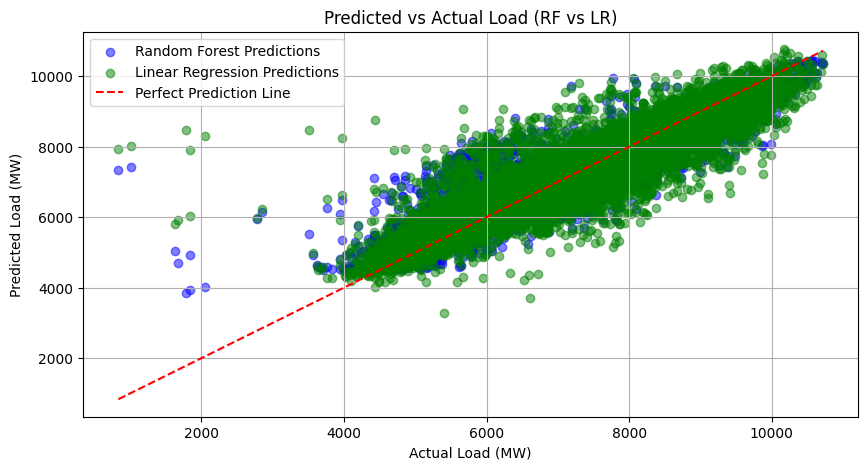

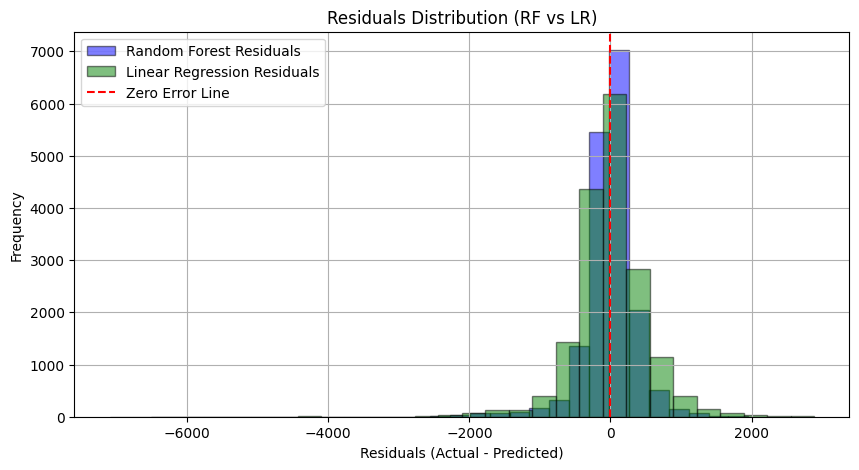

In [13]:

# Convert Spark DataFrames to Pandas for easier plotting
rf_predictions_pd = rf_predictions.select("load", "prediction").toPandas()
lr_predictions_pd = lr_predictions.select("load", "prediction").toPandas()

# Scatter plot of actual vs predicted values for both models
plt.figure(figsize=(10, 5))  # Set the figure size for the plot
# Scatter plot for Random Forest predictions
plt.scatter(rf_predictions_pd["load"], rf_predictions_pd["prediction"], alpha=0.5, label="Random Forest Predictions", color='blue')
# Scatter plot for Linear Regression predictions
plt.scatter(lr_predictions_pd["load"], lr_predictions_pd["prediction"], alpha=0.5, label="Linear Regression Predictions", color='green')
# Add a red dashed line representing the perfect prediction line (where predicted values = actual values)
plt.plot(
    [rf_predictions_pd["load"].min(), rf_predictions_pd["load"].max()],  # X-axis range: min to max of actual load
    [rf_predictions_pd["load"].min(), rf_predictions_pd["load"].max()],  # Y-axis range: min to max of actual load
    color="red",  # Color of the line
    linestyle="--",  # Dashed line style
    label="Perfect Prediction Line"  # Label for the line in the legend
)
# Set labels for the x and y axes
plt.xlabel("Actual Load (MW)")
plt.ylabel("Predicted Load (MW)")
# Set the title of the plot
plt.title("Predicted vs Actual Load (RF vs LR)")
# Display the legend for the two models and the perfect prediction line
plt.legend()
# Enable grid for better readability of the plot
plt.grid(True)
# Show the plot
plt.show()

# Residuals histogram for both models
# Calculate residuals (difference between actual and predicted values) for Random Forest
rf_residuals = rf_predictions_pd["load"] - rf_predictions_pd["prediction"]
# Calculate residuals for Linear Regression
lr_residuals = lr_predictions_pd["load"] - lr_predictions_pd["prediction"]

# Create a histogram to visualize the residuals of both models
plt.figure(figsize=(10, 5))  # Set figure size for the histogram
# Histogram for Random Forest residuals
plt.hist(rf_residuals, bins=30, alpha=0.5, label="Random Forest Residuals", color='blue', edgecolor='k')
# Histogram for Linear Regression residuals
plt.hist(lr_residuals, bins=30, alpha=0.5, label="Linear Regression Residuals", color='green', edgecolor='k')
# Add a red dashed line at zero to represent zero error (ideal point)
plt.axvline(0, color="red", linestyle="--", label="Zero Error Line")
# Set the labels for the x and y axes
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
# Set the title for the histogram
plt.title("Residuals Distribution (RF vs LR)")
# Display the legend for the two models and the zero error line
plt.legend()
# Enable grid for better readability
plt.grid(True)
# Show the histogram plot
plt.show()


### Conclusion from the plots

In both cases (Linear Regression and Random Forest) we can see, that in the higher actual load values, both models perform relatively well. However, in the lower load values both models fail to predict the actual load values. This could be due to the fact that lower values only appear during unpreditable events, such as holidays when the industry is either closed or atleast not operating at full capacity.

We can also tell that the Random Forest model performs better than the Linear Regression model, as the residuals are slightyl more centered around zero and the predicted values are closer to the actual values. We can also compare the RMSE and R² values to further evaluate the models:

Linear Regression:
* RMSE: 520.39
* R²: 0.85

Random Forest:
* RMSE: 381.14
* R²: 0.92

Based on these values, we can conclude that the Random Forest model is more accurate.